In [1]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as sio
import skimage.io
import h5py

import sys
sys.path.append('../Metric/')
sys.path.append('../../Visualization/')
from Metric import *
from Data_Extractor import *

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load & Reorder:

In [2]:
# Load
path_raw_image = "../../Data/090085/All_Data/090085_20170531.h5"
path_road_mask = "../../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/motor_trunk_pri_sec_tert_uncl_track.tif"
path_topleft_coordinate = "../../Data/090085/Road_Data/motor_trunk_pri_sec_tert_uncl_track/posneg_topleft_coordinate_8"

raw_image = np.array(h5py.File(path_raw_image)['scene'])
road_mask = skimage.io.imread(path_road_mask)

data = h5py.File(path_topleft_coordinate, 'r')

pos_topleft_coord = np.array(data['positive_example'])
neg_topleft_coord = np.array(data['negative_example'])
data.close()

print(raw_image.shape, road_mask.shape)
print(raw_image.min())

(7, 7961, 8091) (7961, 8091)
-9999


In [3]:
# Construct training & test set
pos_size = pos_topleft_coord.shape[0]
neg_size = neg_topleft_coord.shape[0]

np.random.shuffle(pos_topleft_coord)
np.random.shuffle(neg_topleft_coord)

Train_Data = Data_Extractor (raw_image, road_mask, 8,
                             pos_topleft_coord = pos_topleft_coord[:int(0.75*pos_size) ,:],
                             neg_topleft_coord = neg_topleft_coord[:int(0.75*neg_size) ,:])

Test_Data  = Data_Extractor (raw_image, road_mask, 8,
                             pos_topleft_coord = pos_topleft_coord[ int(0.75*pos_size):int(0.90*pos_size),:],
                             neg_topleft_coord = neg_topleft_coord[ int(0.75*neg_size):int(0.90*neg_size),:])

print(Train_Data.size, Test_Data.size)

19131279 3826257


Model parameters: 

In [4]:
size = 8
band = 7

# Hyper parameters
conv_out = [0, 64, 128]
last_conv_flatten = conv_out[-1]
layer_out = [0, 192]

class_output = 1 # number of possible classifications for the problem

keep_rate = 0.5 # need regularization => otherwise NaN appears inside CNN

class_weight = [Train_Data.pos_size/Train_Data.size, Train_Data.neg_size/Train_Data.size]

batch_size = 64
learning_rate = 9e-6
epoch = 15

print(class_weight, '[neg, pos]')

[0.014676122803917082, 0.9853238771960829] [neg, pos]


Place holders for inputs and outputs: 

In [5]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, size, size, band], name='x')
center_crop = tf.contrib.layers.flatten(x[:, int(size/2)-1:int(size/2)+2, int(size/2)-1:int(size/2)+2, :])
y = tf.placeholder(tf.float32, shape=[None], name='y')

keep_prob = tf.placeholder(tf.float32, name='keep_prob') # dropout
is_training = tf.placeholder(tf.bool, name='is_training') # batch norm

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.sign

Convolutional Layers:

In [6]:
# Convolutional Layer 1
net = tf.contrib.layers.conv2d(inputs=x, num_outputs=conv_out[1], kernel_size=3, 
                               stride=1, padding='SAME',
                               normalizer_fn=tf.contrib.layers.batch_norm,
                               normalizer_params={'scale':True, 'is_training':is_training},
                               scope='conv1')

net = tf.contrib.layers.max_pool2d(inputs=net, kernel_size=2, stride=2, padding='VALID', scope='pool1')

# Convolutional Layer 2
net = tf.contrib.layers.conv2d(inputs=net, num_outputs=conv_out[2], kernel_size=3, 
                               stride=1, padding='SAME',
                               normalizer_fn=tf.contrib.layers.batch_norm,
                               normalizer_params={'scale':True, 'is_training':is_training},
                               scope='conv2')

net = tf.contrib.layers.max_pool2d(inputs=net, kernel_size=2, stride=2, padding='VALID', scope='pool2')

# # Convolutional Layer 3
# net = tf.contrib.layers.conv2d(inputs=net, num_outputs=conv_out[3], kernel_size=3, 
#                                stride=1, padding='SAME',
#                                normalizer_fn=tf.contrib.layers.batch_norm,
#                                normalizer_params={'scale':True, 'is_training':is_training})

# net = tf.contrib.layers.max_pool2d(inputs=net, kernel_size=2, stride=2, padding='VALID')

# Flattening
net = tf.contrib.layers.flatten(net, scope='flatten')

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.sign

Fully Connected & Output Layer: 

In [7]:
# Dense Layer 1
net = tf.contrib.layers.fully_connected(inputs=net, num_outputs=layer_out[1], scope='dense1')

# Drop out layer:
net = tf.contrib.layers.dropout(inputs=net, keep_prob=keep_prob, is_training=is_training, scope='drop')

# Dense Layer 2
net = tf.concat( [net, center_crop], 1)
net = tf.contrib.layers.fully_connected(inputs=net, num_outputs=class_output, activation_fn=tf.nn.sigmoid, 
                                        scope='dense2')
net = tf.squeeze(net, name='logits')

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Cost function & optimizer:

In [8]:
cross_entropy = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=net, targets=y, 
                                                                        pos_weight=class_weight[1]))

# Ensures that we execute the update_ops before performing the train_step
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.sign

Train & monitor:

In [9]:
saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

learning_curve = []
iteration = int(Train_Data.size/batch_size) + 1

for epoch_num in range(epoch):
    for iter_num in range(iteration):
        
        batch_x, batch_y = Train_Data.get_patches(batch_size=64)
        batch_x = batch_x.transpose((0, 2, 3, 1))
        train_step.run(feed_dict={x: batch_x, y: batch_y, keep_prob: keep_rate, is_training: True})

    # snap shot
    cur_cost = cross_entropy.eval(feed_dict={x:batch_x, y: batch_y, keep_prob: 1, is_training:False})
    print("cross entropy = ", cur_cost)
    learning_curve.append(cur_cost)
print("finish")

cross entropy =  0.6929882
cross entropy =  0.6931472
cross entropy =  0.6931472
cross entropy =  0.6931472
cross entropy =  0.6931472
cross entropy =  0.6929882
cross entropy =  0.6931472
cross entropy =  0.6925114
cross entropy =  0.6929882
cross entropy =  0.6929882
cross entropy =  0.6931472
cross entropy =  0.6931472
cross entropy =  0.69282925
cross entropy =  0.6931472
cross entropy =  0.6931472
finish


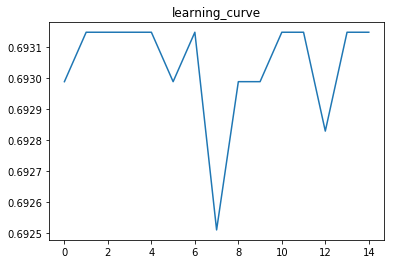

In [10]:
# plot training curve
plt.figsize=(9,5)
plt.plot(learning_curve)
plt.title('learning_curve')
plt.show()

## (Optional) Save the model

In [13]:
save_path = './Result/motor_trunk_pri_sec_tert_uncl_track/'
model_name = 'CNN_8'
saver.save(sess, save_path + model_name)

h5f = h5py.File(save_path + "training_info.h5", 'w')

h5f_Index = h5f.create_group("Index")

h5f_Index_Train = h5f_Index.create_group(name='Train')
h5f_Index_Train.create_dataset (name='pos', data=Train_Data.pos_topleft_coord)
h5f_Index_Train.create_dataset (name='neg', data=Train_Data.neg_topleft_coord)

h5f_Index_Test  = h5f_Index.create_group(name='Test')
h5f_Index_Test.create_dataset (name='pos', data=Test_Data.pos_topleft_coord)
h5f_Index_Test.create_dataset (name='neg', data=Test_Data.neg_topleft_coord)

<HDF5 dataset "neg": shape (3770102, 2), type "<i8">

Evaluate:

In [ ]:
train_metric = Metric()

for img, mask in Train_Data.iterate_data():
    batch = [((img-mu)/sigma).reshape((-1,band,height,width)).transpose((0,2,3,1)).astype(np.float32), 
             np.matrix(mask).astype(int).T]

    # record metric
    pred = prediction.eval(feed_dict={x:batch[0], keep_prob: 1, is_training: False})
    train_metric.accumulate(pred, batch[1])
    
train_metric.print_info()

In [ ]:
test_metric = Metric()

for img, mask in Test_Data.iterate_data():
    batch = [((img-mu)/sigma).reshape((-1,band,height,width)).transpose((0,2,3,1)).astype(np.float32), 
             np.matrix(mask).astype(int).T]
    
    # record metric
    pred = prediction.eval(feed_dict={x:batch[0], keep_prob: 1, is_training: False})
    test_metric.accumulate(pred, batch[1])
    
test_metric.print_info()